# Question 4

In [1]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla

import numpy as np
import random
import time
import pdb
import unittest
from PIL import Image
import matplotlib.pyplot as plt

# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
    return np.linalg.norm(np.subtract(u,v), 1)
    # raise NotImplementedError

# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions 
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0, 
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold, 
                                   high = max_threshold + 1, 
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets 
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as 
# possible, since it is expensive.
# A: The dataset.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)
    
    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors=10):
    distances = map(lambda r: (r, l1(A[r], A[query_index])), range(len(A)))
    best_neighbors = sorted(distances, key=lambda t: t[1])[1:num_neighbors+1]

    return [t[0] for t in best_neighbors]
    # raise NotImplementedError #TODO

In [3]:
def error_measure(A, k=24, L=10):

    functions, hashed_A = lsh_setup(A, k, L)

    error = 0
    for query_index in range(100, 1100, 100):
        best_neighbors_lsh = lsh_search(A, hashed_A, functions, query_index, 3)
        best_neighbors_linear = linear_search(A, query_index, 3)
        d_lsh = 0   
        d_linear = 0
        for i in best_neighbors_lsh: d_lsh += l1(A[query_index], A[i])
        for i in best_neighbors_linear: d_linear += l1(A[query_index], A[i])
        error += d_lsh / d_linear
    return error/10

In [4]:
def average_time(A, k=24, L=10):
    functions, hashed_A = lsh_setup(A, k, L)

    best_neighbors_lsh = []
    best_neighbors_linear = []
    time_lsh = 0
    time_linear = 0
    for query_index in range(100, 1100, 100):
        start_time = time.time()
        best_neighbors_lsh.append(lsh_search(A, hashed_A, functions, query_index, 3))
        time_lsh += time.time() - start_time

        start_time = time.time()
        best_neighbors_linear.append(linear_search(A, query_index, 3))
        time_linear += time.time() - start_time

    print('The average search time for LSH search is', time_lsh / 10)
    print('The average search time for linear search is', time_linear / 10)


In [13]:
average_time(A)

The average search time for LSH search is 0.08589589595794678
The average search time for linear search is 0.31459708213806153


In [21]:
def plot_error(A):
    error_values_L = [] 
    error_values_k = []
    for L in range(10, 22, 2):
        error_values_L.append(error_measure(A, L=L))
    for k in range(16, 26, 2):
        error_values_k.append(error_measure(A, k=k))

    plt.figure(figsize=(15,6))
    plt.subplot(121)
    plt.plot(range(10,22,2), error_values_L, 'ro-')
    plt.xlabel('L')
    plt.ylabel('error value')
    plt.title('k=24')
    plt.subplot(122)
    plt.plot(range(16,26,2), error_values_k, 'bo-')
    plt.xlabel('k')
    plt.ylabel('error value')
    plt.title('L=10')
    plt.savefig('error_values.png')

In [12]:
def plot_near_neighbors(A):
    functions, hashed_A = lsh_setup(A)
    best_neigbors_lsh = lsh_search(A, hashed_A, functions, 100, 10)
    best_neigbors_linear = linear_search(A, 100, 10)
    plot(A, best_neigbors_lsh, 'lsh')
    plot(A, best_neigbors_linear, 'linear')
    plot(A, [100], 'patch')

In [16]:
def problem4():
    A = load_data('q4/data/patches.csv')
    average_time(A)
    plot_error(A)
    plot_near_neighbors(A)
    # raise NotImplementedError

#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

    ### TODO: Write your tests here (they won't be graded, 
    ### but you may find them helpful)

The average search time for LSH search is 0.08553493022918701
The average search time for linear search is 0.32685678005218505


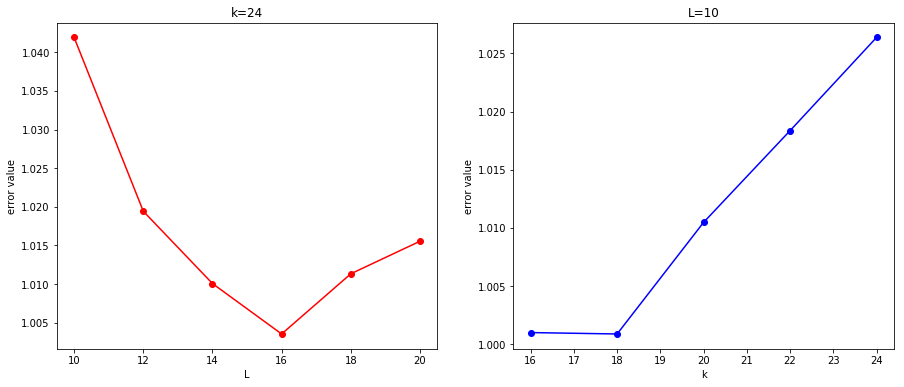

In [22]:
if __name__ == '__main__':
#    unittest.main() ### TODO: Uncomment this to run tests
    problem4()